# Lung Cancer image classifier

We have taken this dataset from [kaggle](https://www.kaggle.com/andrewmvd/lung-and-colon-cancer-histopathological-images) consisting of 25000 images of lungs tissue cells. we are visualizing the Data and Processing for Tumor Detection in the lungs.  Our main goal is to predict to which class does the image belongs.

## Reson for choosing the dataset

Lung cancer is currently one of the most vital diseases in society, and patients are more likely to be cured if the disease is spotted earlier. This project will show the use of Machine Learning to be one of the efficient solutions in healthcare. Radiologists’ workloads have increased significantly in recent years. Some studies found that the average radiologist must interpret an image every 3-4 seconds to meet demand. So with the help of the ml algorithm, I have trained on previously captured radiographic images to recognize the early development of tumors in the lungs.

Algorithms have been trained to recognize complex patterns in radiographic imaging data. They can detect lung cancer from mammograms with remarkable accuracy. The model is showing an accuracy of 91%  and will help to provide diagnostic information 30 times faster than a human. This will also help to also decrease the need for biopsies. 

## About the dataset

This dataset contains 15,000 histopathological images with 3 classes. All images are 768 x 768 pixels in size and are in jpeg file format.
The images were generated from an original sample of HIPAA compliant and validated sources, consisting of 750 total images of lung tissue (250 benign lung tissue, 250 lung adenocarcinomas, and 250 lung squamous cell carcinomas) and 500 total images of colon tissue (250 benign colon tissue and 250 colon adenocarcinomas) and augmented to 25,000 using the Augmentor package.  
There are three classes in the dataset, each with 5,000 images, being:  
* Lung benign tissue
* Lung adenocarcinoma
* Lung squamous cell carcinoma

## Introduction 

In this project, I will be using the deep learning to implement a neural network for lung cancer image classfication.

## Setting up the environment
Import all the libraries that will be using.

In [1]:
import warnings
import cv2
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Set up the file directory

In [2]:
lung_dir='./lung_colon_image_set/lung_image_sets/'
lung_aca='./lung_colon_image_set/lung_image_sets/lung_aca/'
lung_n='./lung_colon_image_set/lung_image_sets/lung_n/'
lung_scc='./lung_colon_image_set/lung_image_sets/lung_scc/'

## Data explorations

We are exploring the data that we will be using for traing the model.

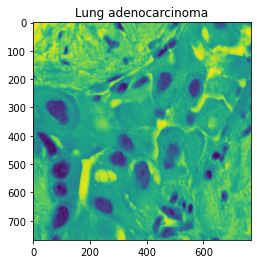

Image Shape :  (768, 768)


In [3]:
image = cv2.imread(lung_aca+'lungaca1.jpeg',0)
plt.title('Lung adenocarcinoma')
plt.imshow(image)
plt.show()
print('Image Shape : ',image.shape)

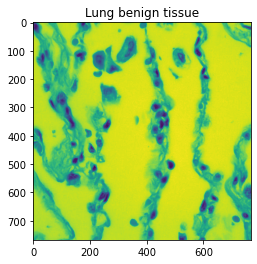

Image Shape :  (768, 768)


In [4]:
image = cv2.imread(lung_n+'lungn1.jpeg',0)
plt.title('Lung benign tissue')
plt.imshow(image)
plt.show()
print('Image Shape : ',image.shape)

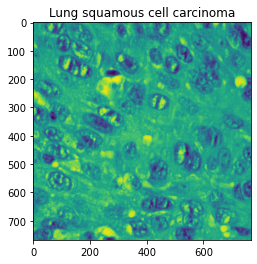

Image Shape :  (768, 768)


In [5]:
image = cv2.imread(lung_scc+'lungscc1.jpeg',0)
plt.title('Lung squamous cell carcinoma')
plt.imshow(image)
plt.show()
print('Image Shape : ',image.shape)

### Plotting all the three classes of images(3 each) in a grid.

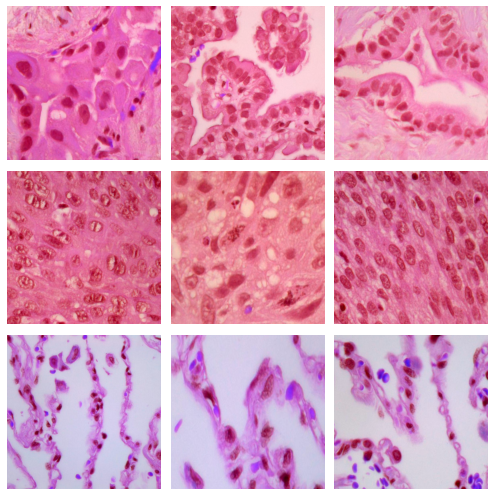

In [8]:
lst=glob.glob(lung_aca+ "*.jpeg")[:3] + glob.glob(lung_scc+ "*.jpeg")[:3] + glob.glob(lung_n+ "*.jpeg")[:3]

plt.figure(figsize=(7, 7))
i=1
for dir in lst[:9]:
    plt.subplot(3, 3, i)
    image = cv2.imread(dir)
    plt.axis("off")
    plt.imshow(image,cmap='gray')
    i+=1
plt.tight_layout()    
plt.show()

## Preprocessing the data

We are using Keras ImageDataGenerator to create Image augmentation. Image augmentation is a technique of applying different transformations such as a slit, rotate, resize, shift, etc. to the original images which results in multiple transformed copies of the same image. Each copy, however, is different from the other in certain aspects depending on the augmentation techniques you apply like shifting, rotating, flipping, etc. Applying these small amounts of variations on the original image does not change its target class but only provides a new perspective of capturing the object in real life. And so, we use it is quite often for building deep learning models.

For augmentation, we will be using

* image rescale: Rescaling for normalization of data.
* shear range transformation: Shear angle in a counter-clockwise direction in degrees.
* rotation_range: Degree range for random rotations.
* brightness_range: For random brightness change.
* horizontal_flip: For random horizontal flip.
* vertical_flip: For random vertical flip.
* zoom_range: Range for random zoom. If a float, [lower, upper].
* width_shift_range : Shift randomly along width.
* height_shift_range: Shift randomly along the height.

In [6]:
def datapreprocessing(main_dir,batch_size):
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    
    train_gen = ImageDataGenerator(zoom_range=0.3,
                                   rescale=1.0/255,
                                   shear_range=0.2,
                                   fill_mode='nearest',
                                   rotation_range=90,
                                   brightness_range=[0.4,1.5],
                                   horizontal_flip=True, vertical_flip=True,
                                   width_shift_range=0.2, height_shift_range=0.2,
                                   validation_split=0.1          # Dividing the dataset (train-validation split)
                                  )

    train_generator = train_gen.flow_from_directory(
        directory=main_dir,
        target_size=(256,256),                 # resizing it to (256,256) pixel.
        batch_size=batch_size,
        color_mode="grayscale",
        shuffle=True,
        subset='training',
        class_mode='categorical')   # set as training data

    validation_generator = train_gen.flow_from_directory(
        directory=main_dir,
        batch_size=batch_size,
        class_mode='categorical',
        target_size=(256,256),                # resizing it to (256,256) pixel.
        color_mode="grayscale",
        shuffle=True,
        subset='validation') # set as validation data
    
    return train_generator,validation_generator

In [7]:
traingen,valigen = datapreprocessing(lung_dir,20)

Found 13500 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.


## Classes indices

In [11]:
print("Training Data classes : ",traingen.class_indices)

Training Data classes :  {'lung_aca': 0, 'lung_n': 1, 'lung_scc': 2}


## Train-Test Size

In [12]:
print("Train data size : ",traingen.samples)
print("Test data size : ",valigen.samples)

Train data size :  13500
Test data size :  1500


## Plotting number of data of each classes in training data

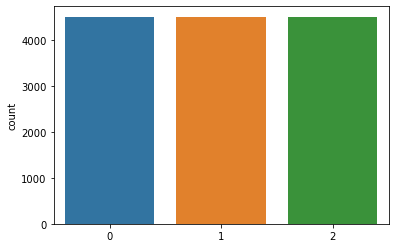

In [8]:
warnings.simplefilter("ignore")
sns.countplot(traingen.labels)
plt.show()

## Building Model's Architecture

In [9]:
def imageclf2(input_shape):
    from tensorflow import keras as ks

    model = ks.models.Sequential()
    model.add(ks.layers.Conv2D(8,(3,3),
                               strides=1,
                               activation="relu",
                               padding='same',
                               name="layer1",
                               input_shape=input_shape))
    model.add(ks.layers.MaxPooling2D(pool_size=2,strides=2))
    
    model.add(ks.layers.Conv2D(8,(3,3),strides=1,padding="same",activation="relu",name="layer2"))
    model.add(ks.layers.MaxPooling2D(pool_size=2,strides=2))
    
    
    model.add(ks.layers.Flatten())
    model.add(ks.layers.Dense(256,activation="relu",
                              name="layer5"))
    model.add(ks.layers.Dense(128,activation="relu",
                              name="layer6"))
    
    model.add(ks.layers.Dense(3,activation='softmax',
                              name="output"))
    model.summary()
    return model

## Building the Compiler

In [10]:
def compiler2(model,train_generator,valid_generator,epchs,bsize=20,lr=0.0001):

    from tensorflow import keras as ks
    callbck = ks.callbacks.EarlyStopping(monitor='val_loss',patience=4,verbose=2,
                                         restore_best_weights=True,) 
    
    opt = ks.optimizers.Adam(learning_rate=lr)
    
    model.compile(loss='categorical_crossentropy',
                      optimizer=opt,
                      metrics=["accuracy"])
    history = model.fit(train_generator,
                        epochs=epchs,
                        callbacks=[callbck],
                        validation_data=valid_generator,
                        verbose = 1)

    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='valid_acc')

    plt.title('lrate='+str(lr), pad=-50)
    plt.legend()
    plt.grid(True)
    return model,history

## Creating the model

In [16]:
model01 = imageclf2(traingen.image_shape)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Conv2D)              (None, 256, 256, 8)       80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 8)       0         
_________________________________________________________________
layer2 (Conv2D)              (None, 128, 128, 8)       584       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 8)         0         
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
layer5 (Dense)               (None, 256)               8388864   
_________________________________________________________________
layer6 (Dense)               (None, 128)               3

##  Fitting the model with train and validation data

Epoch 1/10
675/675 [==============================] - 721s 1s/step - loss: 0.8770 - accuracy: 0.5787 - val_loss: 0.8610 - val_accuracy: 0.5927
Epoch 2/10
675/675 [==============================] - 501s 742ms/step - loss: 0.7664 - accuracy: 0.6711 - val_loss: 0.7707 - val_accuracy: 0.6673
Epoch 3/10
675/675 [==============================] - 478s 708ms/step - loss: 0.6372 - accuracy: 0.7425 - val_loss: 0.6815 - val_accuracy: 0.7040
Epoch 4/10
675/675 [==============================] - 495s 733ms/step - loss: 0.5832 - accuracy: 0.7950 - val_loss: 0.6096 - val_accuracy: 0.7713
Epoch 5/10
675/675 [==============================] - 495s 732ms/step - loss: 0.5285 - accuracy: 0.8333 - val_loss: 0.5468 - val_accuracy: 0.8213
Epoch 6/10
675/675 [==============================] - 525s 777ms/step - loss: 0.4914 - accuracy: 0.8662 - val_loss: 0.5158 - val_accuracy: 0.8400
Epoch 7/10
675/675 [==============================] - 498s 738ms/step - loss: 0.4597 - accuracy: 0.8833 - val_loss: 0.4789 - va

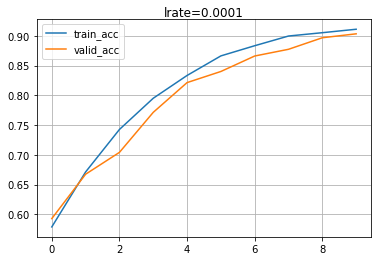

In [11]:
model_com01 = compiler2(model01,traingen,valigen,10)

## Predicting the model

We will be using the validation image data generated from the image data generator to predict the test image and its accuracy.

In [19]:
pred=model01.predict(valigen)
prediction = np.argmax(pred, axis=1)

Our predctions will be in the form of probability of being each of the three classes.

In [21]:
pred

array([[0.7110411 , 0.05125392, 0.237705  ],
       [0.3015203 , 0.5101215 , 0.18835819],
       [0.56458414, 0.08436313, 0.35105276],
       ...,
       [0.71213424, 0.02237622, 0.2654896 ],
       [0.6529092 , 0.27032974, 0.07676104],
       [0.24663211, 0.00209461, 0.7512732 ]], dtype=float32)

## Evaluating the model

For evaluating the accuracy of the model we will be using sklearn confusion_matrix, classification_report, accuracy_score. We have come up with an accuracy of **90.33%**.

In [27]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

print("Accuracy Store : 0.9033",accuracy_score(valigen.classes,prediction))
print("Confusion Matrix : \n",confusion_matrix(valigen.classes,prediction))
print("Classification Report : \n",classification_report(valigen.classes,prediction))

Accuracy Store : 0.9033
Confusion Matrix : 
 [[436 34 30]
[24 471 15]
[32 21 457]]
Classification Report : 
                precision    recall  f1-score   support

           0       0.88      0.87      0.87       500
           1       0.89      0.92      0.91       500
           2       0.91      0.91      0.90       500

    accuracy                           0.91      1500
   macro avg       0.89      0.90      0.91      1500
weighted avg       0.89      0.90      0.91      1500
